In [1]:
import os 
import string
import struct
import numpy as np

def cast(val):
    if val.isdigit():
        val = int(val)
    elif " " in val:
        val = val.split(" ")
        val = [cast(v) for v in val]
    else:
        try:
            val = float(val)
        except ValueError:
            pass
    return val

def parse_OVF(filename):
    state = 0
    with open(filename, "rb") as f:
        properties = {}
        raw_data = b""
        for line in f:
            if state == 0:
                line = line.decode()
                line = line[1:].strip()
                line = line.lower()
                if line.startswith("begin"):
                    if "data" in line:
                        state = 1
                    else:
                        pass
                else:
                    if line.startswith("end"):
                        continue
                    
                    if ":" in line:
                        try:
                            key, *val = line.split(":")
                            val = ("".join(val)).strip()
                            val = cast(val)
                            properties[key] = val
                        except Exception:
                            print(f"multiple ':' on line : \"{line}\". Should it be that way ?")

            else:
                if line.startswith(b"#"):
                    break
                line.replace(b"# End: Data Binary 4\n", b"")
                raw_data += line
        
        raw_data = raw_data[:-1]
        i = len(raw_data) // 24
        for j in range(i):
            print(struct.unpack("ffffff", raw_data[24 * j:(j + 1) *24]))
        print(len(raw_data)% 24)

def read_OVF_as_np(filename):
    file = (filename.split("/")[-1]).split(".")[0] + ".npy"
    os.system(f"mumax3-convert -numpy -o . {filename}")
    mat = np.load(file)
    os.system(f"rm {file}")
    return mat

In [2]:
mat = read_OVF_as_np(os.path.join("skyrmion.out", "img.ovf"))

skyrmion.out/img.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] skyrmion.out/img.ovf	-> img.npy


In [3]:
vecField = mat[:, 0, :, :].transpose(1, 2, 0)
print(vecField.shape)

(64, 64, 3)


In [13]:
x_s, y_s, _ = vecField.shape 
every = 1
s = 1e-3
xs, ys, zs = [], [], []
mxs, mys, mzs = [], [], []
y_offset = 20
x_offset = y_offset
scale = 100

for y in range(y_offset, y_s - y_offset, every):
    for x in range(x_offset, x_s - x_offset, every):
        xs.append(scale * x)
        ys.append(scale * y)
        zs.append(0)

        mx,my,mz = vecField[y, x]
        mxs.append(mx)
        mys.append(my)
        mzs.append(mz)

In [16]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Cone(x=xs, y=ys, z=zs, u=mxs, v=mys, w=mzs, sizemode="scaled", sizeref=0.01))

fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))

fig.show()

/tmp/ipykernel_92681/2740234268.py:5: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



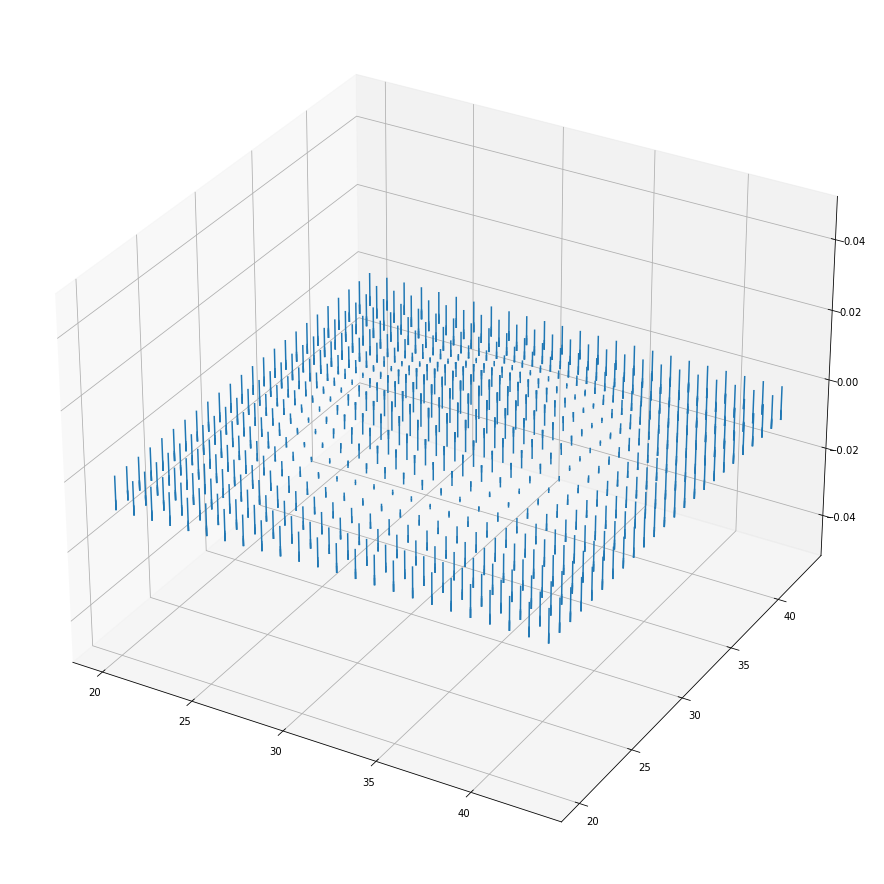

In [10]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')

plt.quiver(xs, ys, zs, mxs, mys, mzs, length=0.01)

plt.show()